In [1]:
pip install transformers torch sentence-transformers bertopic

^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from transformers import pipeline

# Load pre-trained FinBERT model
classifier = pipeline("text-classification", model="ProsusAI/finbert")

# Example financial news
news = "Federal Reserve raises interest rates, impacting banking stocks."

# Classify the news
result = classifier(news)

# Print the result
print(result)


Device set to use cpu


[{'label': 'negative', 'score': 0.9345744848251343}]


In [ ]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import hdbscan

# Load Sentence Transformer model for better embeddings
# embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
# embedding_model = SentenceTransformer("nlpaueb/finbert-twitter")  # Finance-focused
embedding_model = SentenceTransformer("sentence-transformers/paraphrase-MiniLM-L6-v2")



# Configure HDBSCAN to prevent too many -1 (outliers)
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=2, metric='euclidean', cluster_selection_method='eom')

# Train BERTopic with custom HDBSCAN settings
topic_model = BERTopic(
    embedding_model=embedding_model,
    hdbscan_model=hdbscan_model,  # Pass custom clustering model
    nr_topics="auto"  # Let the model determine the number of topics
)

# Sample financial news headlines
news_headlines = [
    "Federal Reserve raises interest rates, impacting banking stocks.",
    "McDonald's revenue surges as fast food demand rises.",
    "Tesla unveils new electric vehicle model with advanced AI.",
    "Amazon expands cloud computing services globally.",
    "Gold prices rise amid economic uncertainty.",
    "Apple releases new iPhone model with advanced AI features.",
    "Bitcoin surges as institutional investors show interest.",
    "Government announces tax cuts for small businesses.",
    "Oil prices decline due to reduced global demand.",
    "Facebook faces new regulations over data privacy concerns."
]

# Train BERTopic
topics, _ = topic_model.fit_transform(news_headlines)

# Show results
for i, topic in enumerate(topics):
    print(f"News: {news_headlines[i]} -> Cluster: {topic}")

# Print topic information
print("\nTopic Info:\n", topic_model.get_topic_info())


News: Federal Reserve raises interest rates, impacting banking stocks. -> Cluster: 0
News: McDonald's revenue surges as fast food demand rises. -> Cluster: 0
News: Tesla unveils new electric vehicle model with advanced AI. -> Cluster: -1
News: Amazon expands cloud computing services globally. -> Cluster: 1
News: Gold prices rise amid economic uncertainty. -> Cluster: -1
News: Apple releases new iPhone model with advanced AI features. -> Cluster: -1
News: Bitcoin surges as institutional investors show interest. -> Cluster: 1
News: Government announces tax cuts for small businesses. -> Cluster: -1
News: Oil prices decline due to reduced global demand. -> Cluster: -1
News: Facebook faces new regulations over data privacy concerns. -> Cluster: -1

Topic Info:
    Topic  Count                                   Name  \
0     -1      6               -1_new_advanced_model_ai   
1      0      2       0_rates_impacting_reserve_stocks   
2      1      2  1_institutional_expands_bitcoin_cloud   



In [ ]:
!pip install spacy

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


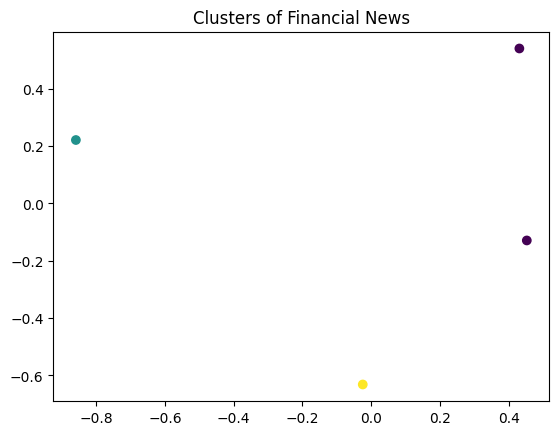

Article 1 is about Healthcare: Apple announced record profits in Q4 due to strong iPhone sales.
Article 2 is about Technology: Tesla's stock surged after the release of their new electric vehicle.
Article 3 is about Technology: Oil prices dropped as OPEC announced increased production.
Article 4 is about Energy: Microsoft partners with healthcare providers to improve patient data systems.


In [ ]:
import spacy
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import hdbscan
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Preprocess
# spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")
def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

news_articles = [
    "Apple announced record profits in Q4 due to strong iPhone sales.",
    "Tesla's stock surged after the release of their new electric vehicle.",
    "Oil prices dropped as OPEC announced increased production.",
    "Microsoft partners with healthcare providers to improve patient data systems."
]
preprocessed_articles = [preprocess_text(article) for article in news_articles]

# Step 2: Generate Embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(preprocessed_articles)

# Step 3: Cluster (K-Means)
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Step 4: Visualize
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='viridis')
plt.title("Clusters of Financial News")
plt.show()

# Step 5: Map Clusters to Sectors
sector_mapping = {0: "Technology", 1: "Energy", 2: "Healthcare"}
for i, cluster in enumerate(clusters):
    sector = sector_mapping.get(cluster, "Unknown")
    print(f"Article {i+1} is about {sector}: {news_articles[i]}")

In [ ]:
!pip install faiss-cpu


111.01s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 31.4 MB/s eta 0:00:0000:0100:01


/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]


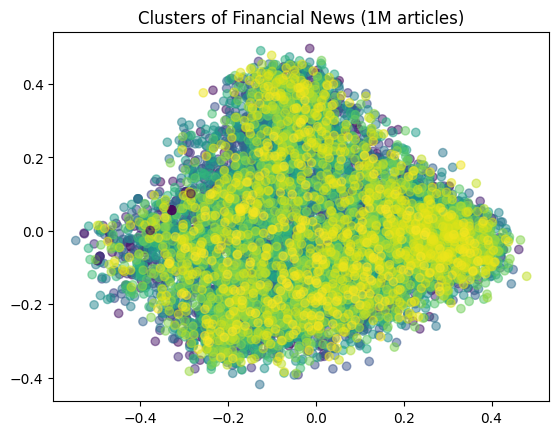

Article 1 is about Sector 0: disney marathon how to register and qualify check dates and entry fee
Article 2 is about Sector 1: bharti airtel services to acquire 97 1 stake in beetel teletech
Article 3 is about Sector 2: fallout 76 nuke codes launch site locations heres what you may want to know
Article 4 is about Sector 3: is retirement on your list in 2024 here are details about taxes you should know
Article 5 is about Sector 4: raise a glass to gift city why the recent amendment to the teetotaller mandate is a gamechanger in the dry state


In [ ]:
import spacy
import numpy as np
import faiss
import hdbscan
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import IncrementalPCA
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd


dataFrame = pd.read_csv("../Data Collection/data.csv")

# print(dataFrame["News"])

data = dataFrame["News"].head(10000)

# Load spaCy model with disabled components for speed
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def preprocess_texts(texts, batch_size=10000):
    """Efficiently preprocess large text datasets using spaCy's pipe()"""
    processed_texts = []
    for doc in tqdm(nlp.pipe(texts, batch_size=batch_size), total=len(texts), desc="Preprocessing"):
        tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
        processed_texts.append(" ".join(tokens))
    return processed_texts

# Simulate a large dataset (Replace with your real dataset)
num_samples = len(data)
news_articles = data

# Step 1: Preprocess Texts
preprocessed_articles = preprocess_texts(news_articles)

# Step 2: Generate Embeddings using a powerful model
model = SentenceTransformer("all-mpnet-base-v2")  # Better embeddings for large-scale datasets
batch_size = 100
embeddings = np.vstack([model.encode(preprocessed_articles[i:i+batch_size], show_progress_bar=True) 
                        for i in range(0, len(preprocessed_articles), batch_size)])

# Step 3: Cluster using FAISS (fast for large datasets)
num_clusters = 100  # Adjust based on dataset
faiss_index = faiss.IndexFlatL2(embeddings.shape[1])  
faiss_index.add(embeddings)
_, clusters = faiss_index.search(embeddings, 1)  # Assigns each point to a cluster

# Step 4: Reduce Dimensionality for Visualization (Incremental PCA)
ipca = IncrementalPCA(n_components=2, batch_size=50000)
reduced_embeddings = ipca.fit_transform(embeddings)

# Step 5: Visualize
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters.flatten(), cmap="viridis", alpha=0.5)
plt.title("Clusters of Financial News (1M articles)")
plt.show()

# Step 6: Print sample results
sector_mapping = {i: f"Sector {i}" for i in range(num_clusters)}
for i in range(5):  # Show first 5
    cluster = clusters[i][0]
    sector = sector_mapping.get(cluster, "Unknown")
    print(f"Article {i+1} is about {sector}: {news_articles[i]}")


In [ ]:
import spacy
import numpy as np
import faiss
import hdbscan
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import IncrementalPCA

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Load data
dataFrame = pd.read_csv("../Data Collection/data.csv")
data = dataFrame["News"].head(10000)  # Using first 10,000 articles

# Load spaCy model (disabling unnecessary components for speed)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def preprocess_texts(texts, batch_size=10000):
    """Efficiently preprocess large text datasets using spaCy's pipe()"""
    processed_texts = []
    for doc in tqdm(nlp.pipe(texts, batch_size=batch_size), total=len(texts), desc="Preprocessing"):
        tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
        processed_texts.append(" ".join(tokens))
    return processed_texts

# Preprocess texts
preprocessed_articles = preprocess_texts(data)

Preprocessing: 100%|██████████| 10000/10000 [00:13<00:00, 725.28it/s]


In [ ]:
# Generate Embeddings
model = SentenceTransformer("all-mpnet-base-v2")  
batch_size = 100
embeddings = np.vstack([model.encode(preprocessed_articles[i:i+batch_size], show_progress_bar=True) 
                        for i in range(0, len(preprocessed_articles), batch_size)])

# Clustering using FAISS (fast)
num_clusters = 10  # Adjust based on dataset
faiss_index = faiss.IndexFlatL2(embeddings.shape[1])  
faiss_index.add(embeddings)
_, clusters = faiss_index.search(embeddings, 1)  # Assign each point to a cluster

# Alternative: Using HDBSCAN for better clustering
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=50)
hdbscan_labels = hdbscan_clusterer.fit_predict(embeddings)

Batches: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


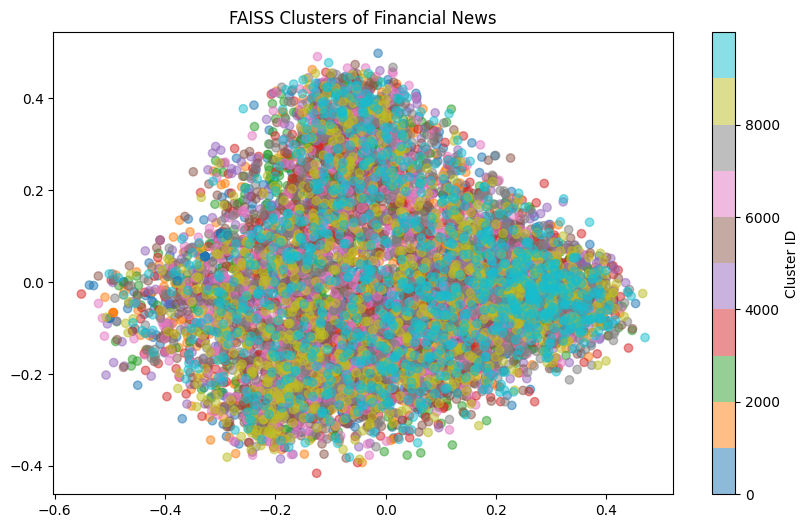

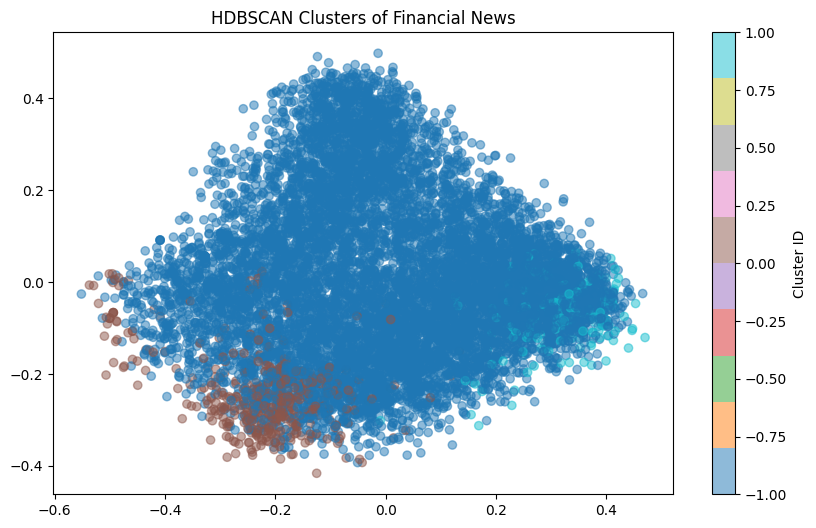

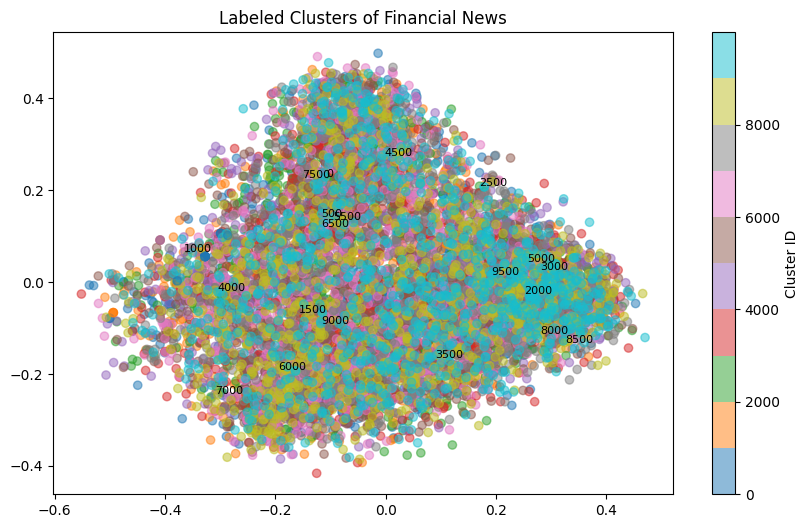

Article 1 is about Banking: disney marathon how to register and qualify check dates and entry fee
Article 2 is about Technology: bharti airtel services to acquire 97 1 stake in beetel teletech
Article 3 is about Energy: fallout 76 nuke codes launch site locations heres what you may want to know
Article 4 is about Retail: is retirement on your list in 2024 here are details about taxes you should know
Article 5 is about Healthcare: raise a glass to gift city why the recent amendment to the teetotaller mandate is a gamechanger in the dry state


In [ ]:
# Reduce Dimensionality for Visualization
ipca = IncrementalPCA(n_components=2, batch_size=5000)
reduced_embeddings = ipca.fit_transform(embeddings)

# Visualize FAISS Clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters.flatten(), cmap="tab10", alpha=0.5)
plt.colorbar(label="Cluster ID")  # Add legend
plt.title("FAISS Clusters of Financial News")
plt.show()

# Visualize HDBSCAN Clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=hdbscan_labels, cmap="tab10", alpha=0.5)
plt.colorbar(label="Cluster ID")  # Add legend
plt.title("HDBSCAN Clusters of Financial News")
plt.show()

# Label some data points for clarity
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters.flatten(), cmap="tab10", alpha=0.5)
for i in range(0, len(reduced_embeddings), 500):  # Label every 500th point
    plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], str(clusters[i][0]), fontsize=8, color="black")
plt.title("Labeled Clusters of Financial News")
plt.colorbar(label="Cluster ID")
plt.show()

# Map clusters to financial sectors
sector_mapping = {
    0: "Banking",
    1: "Technology",
    2: "Energy",
    3: "Retail",
    4: "Healthcare",
    5: "Automotive",
    6: "Real Estate",
    7: "Pharmaceuticals",
    8: "Consumer Goods",
    9: "Aerospace",
}

# Print sample results
for i in range(5):  # Show first 5 articles
    cluster = clusters[i][0]
    sector = sector_mapping.get(cluster, "Unknown")
    print(f"Article {i+1} is about {sector}: {data.iloc[i]}")


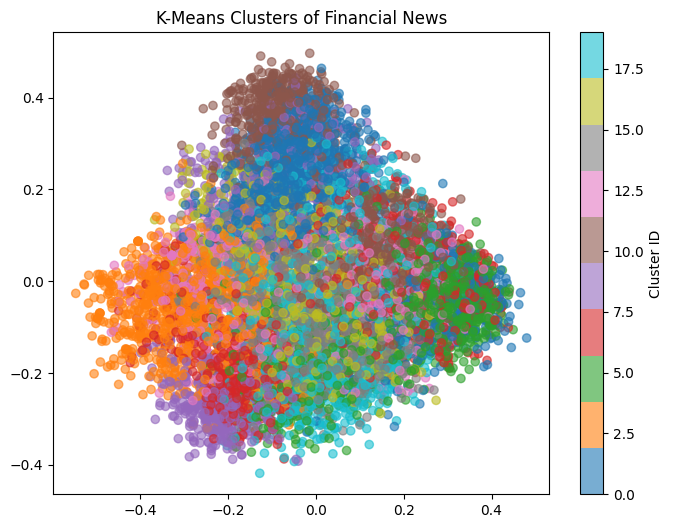


Cluster 0 Samples:
fallout 76 nuke codes launch site locations heres what you may want to know
when psus start to flex their muscles
listening to imagine

Cluster 1 Samples:
ram temple premises in ayodhya to be decked up with flowers from bhopal
bjp readies 2 month plan to welcome pilgrims to ayodhya
bjp accuses owaisi of making provocative remarks on consecration of ram temple

Cluster 2 Samples:
hsbc mf cautions against high return expectations in 2024 picks 5 sectoral themes
new year top 6 make or break events for stock investors in 2024
multibagger bhel shares jump 6 hit 52 week high heres why

Cluster 3 Samples:
vodafone idea shares hit fresh 52 week high jump up to 37 in two sessions
diffusion engineers files ipo papers with sebi
sale of 30th tranche of electoral bonds to start on tuesday

Cluster 4 Samples:
demonstrating democracy the 2024 poll cycle is a strategic opportunity that can provide india leverage
assam cm sarma rules out possibility of immediate talks with paresh ba

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# Step 3: Apply K-Means clustering
num_clusters = 20  # Adjust based on dataset
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(embeddings)

# Step 4: Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Step 5: Visualize clusters
plt.figure(figsize=(8,6))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap="tab10", alpha=0.6)
plt.title("K-Means Clusters of Financial News")
plt.colorbar(scatter, label="Cluster ID")
plt.show()

# Step 6: Display sample articles by cluster
for i in range(num_clusters):
    print(f"\nCluster {i} Samples:")
    print("\n".join(data.iloc[np.where(clusters == i)[0][:3]]))

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import umap
from collections import Counter

# Load your dataset (replace with actual dataset)
data = pd.read_csv("../Data Collection/data.csv")  # Ensure dataset has a 'text' column
texts = data['News'].astype(str)

# Step 1: TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(texts)

# Step 2: Apply K-Means Clustering
num_clusters = 20  # Adjust based on dataset
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
data['cluster'] = kmeans.fit_predict(X)

# Step 3: Dimensionality Reduction using UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding = umap_model.fit_transform(X.toarray())

# Step 4: Visualization
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=data['cluster'], cmap='tab10', alpha=0.7)
plt.colorbar(label="Cluster ID")
plt.title("TF-IDF + K-Means Clusters of Financial News")
plt.show()

# Step 5: Show Top Words Per Cluster
def get_top_words_per_cluster(kmeans, vectorizer, num_words=10):
    terms = vectorizer.get_feature_names_out()
    top_words = {}
    for i in range(num_clusters):
        center_words = kmeans.cluster_centers_[i].argsort()[-num_words:][::-1]
        top_words[i] = [terms[idx] for idx in center_words]
    return top_words

top_words = get_top_words_per_cluster(kmeans, vectorizer)
for cluster, words in top_words.items():
    print(f"Cluster {cluster}: {', '.join(words)}")


/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


: 